# Notebook Hannah

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

## Hypothetisch terrein

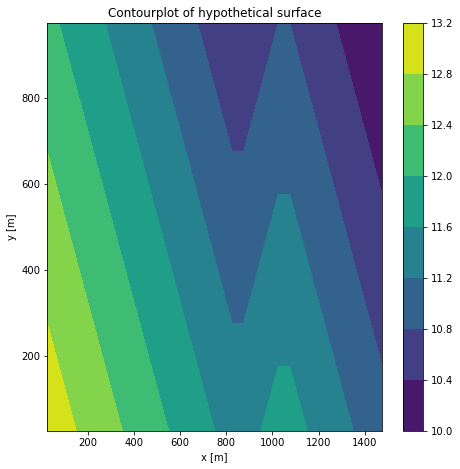

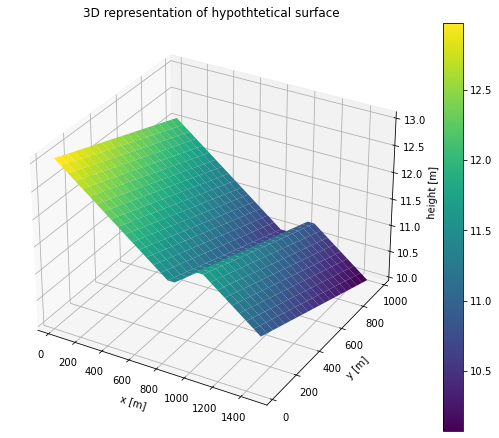

In [9]:
runfile('Grid_hypoth.py')
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

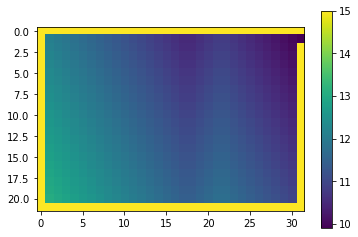

In [10]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.imshow(np.flipud(grid_imag))
plt.colorbar()

## Outflux functies en time loop voor variabele $\Delta$t

Aangepaste OutfluxNH functie voor de eerste loop; heeft geen $\Delta$t als input en berekent geen v*.

In [11]:
def OutfluxNH2_init(NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

Aangepaste OutfluxNH functie voor alle overige loops; heeft $\Delta$t uit de vorige loop als input en berekent op basis van de met v gecorrigeerde v* een nieuwe $\Delta$t.

In [12]:
def OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.max(vj_list)
    
    return Fout, vjmax_NH

Time loop:

In [18]:
# Parameters definiëren
Acell = deltax*deltay
tend = 200*60
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
deltat = 10*60
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
depths_imag_new[-2,-1] = 0 #uitstroomcel legen
# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
        deltat = deltax/np.max(vjmax_list)
    print(deltat)
    t = t + deltat
    t_list.append(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #depths_imag_new[-2,-1] = 0 #uitstroomcel legen. Even niet doen voor vergl
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    depths_list.append(depths_imag_new)

492.8888079942049
259.7611136396887
184.16333365477897
153.0260225048597
146.01520426802824
140.70188449634128
130.55698798830642
122.72103609098954
116.21977310783183
110.5807123649195
105.31842756877731
101.18806945060672
97.31583852953032
94.17156602450329
91.03143524845925
88.68275771971607
86.59688453331594
84.70254410462438
82.54176449593318
80.41602105427026
78.62213277413548
76.98506985735077
75.26235013563377
73.72122208386858
72.4824721691759
71.6143682916173
70.88934215084049
70.06762812981745
69.48010150617563
69.00595333687149
68.54213461019911
68.29868021334336
67.84123568964877
67.8091302985776
67.36616376853475
67.43576822650418
67.11937370196138
67.28295033450176
67.1383902609674
67.19748001928382
67.26238157526444
67.23553235293802
67.40486670544058
67.44741632124877
67.68427239506414
67.74450204022219
67.26129137466894
65.77591328896887
67.35200128988252
65.98965068140134
67.03432664301626
65.74012194936374
66.35339354784855
65.29987222853742
66.45458559909719
64.316

C:\Users\olivi\AppData\Local\Temp/ipykernel_11220/2238314007.py:83: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
C:\Users\olivi\AppData\Local\Temp/ipykernel_11220/2238314007.py:84: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


66.82031694945874
66.82031694945874
66.82031694945874
66.82031694945874
66.82031694945874
67.46996630653817
67.10493597069026
68.01194397270766
67.92760476853192
68.27383692878998
68.39572565672545
68.54699664307867
68.7685942178846
68.87858914210187
69.135581381654
69.28505860176779
69.28505860176779
69.28505860176779
69.28505860176779
69.28505860176779
70.52813519784443
70.83907868263482
71.07546743281422
71.39497964887764
71.67231777346035
72.02014754616684
72.07886339152844
72.56219547196423
72.71026409377018
73.15882145122568
73.4068202498069
73.82821083250816
74.14160240539431
74.55779241724987
74.91756571186605
75.3377749167527
75.73110023843975
76.1589177769224
76.57353280320876
76.6651776929884
76.63267015189118
76.38146118806777
76.32758239395487
76.06451326214017
75.96210215134754
75.71287404984314
75.59615626017623
76.75714869279513
74.90076260513649
73.38165287631098
76.68001564398735
73.4392060339252
75.72580744196756
73.60563656801234
75.21895178213121
73.77810818067425


In [21]:
depths_list[0][1:-1,1:-1]

array([[0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333],
       [0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333],
       [0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.

.................................................

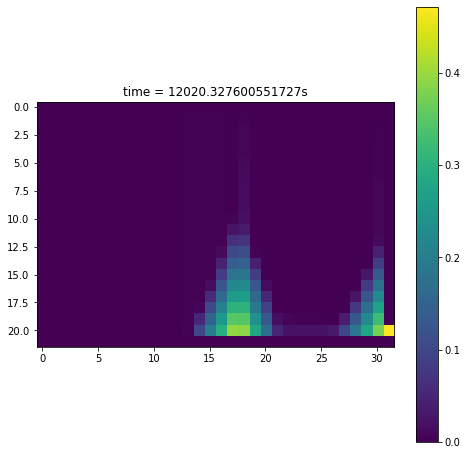

In [19]:
fps = 3
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_variabeleDeltat_nancorr_nooutflux.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

Proberen plotten zonder randen

.................................................

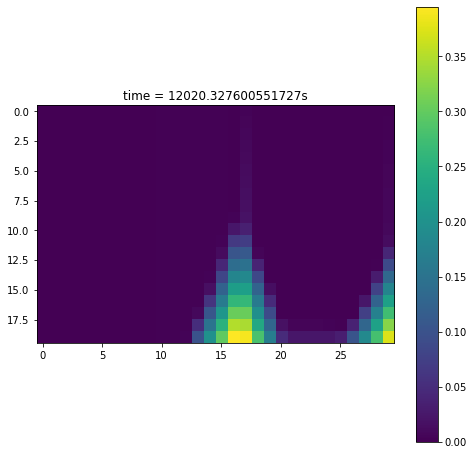

In [24]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)
#probeer te plotten zonder de randen
fps = 3
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list_bis[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list_bis[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list_bis[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_variabeleDeltat_nancorr_nooutflux_noedge.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

In [23]:
depths_list[:]

[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.        ],
        [0.        , 0.00333333, 0.00333333, 0.00333333, 0.00333333,
         0.00333333, 0.00333333, 0.

## Experiment met $\Delta$t
Ik heb het script behorend bij de aangepaste flux_calculation functie (###) hieronder eens proberen uit te schrijven, maar heb er nog vragen bij...

In [15]:
# Parameters definiëren
Acell = deltax*deltay
deltat = 5 #constante tijdstap in s 
vmax_CFL = deltax/deltat #laat 10 m/s als maximale snelheid toe met deltax=50
tend = 5000
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
deltat = 5 #zo dus voor 5 seconden regen 
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)

# Iteraties in de tijd
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    deltat_new = [] ##aanpassing
    # V: deltat_new voor elke tijdstap updaten?
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F1, F2, F4, F5, deltat_v = OutfluxNH(NH_h, NH_d, Acell, deltat, deltax, vmax_CFL)
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # Deltat_v opslaan 
            deltat_new.append(delta_v) ##aanpassing
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    depths_imag_new[-2,-1] = 0 #uitstroomcel legen
    deltat = np.min(np.array(deltat_new)) ##aanpassing
    t = t + deltat 
    t_list.append(t)
    depths_list.append(depths_imag_new)

NameError: name 'OutfluxNH' is not defined